Normalization stats:
Mean: tensor([-5699.4873,  8023.7510])
Std: tensor([601.8121, 847.6780])
History range before norm: -5771.21 to 8124.70
History range after norm: -0.12 to 0.12

Epoch 50/200
epoch loss: 0.00024762318935245275
Average loss: 0.000248

Prediction Statistics:
Average prediction error: 32.13 meters
Final position error: 53.57 meters
Trajectory length - History: 11 steps, Future: 80 steps


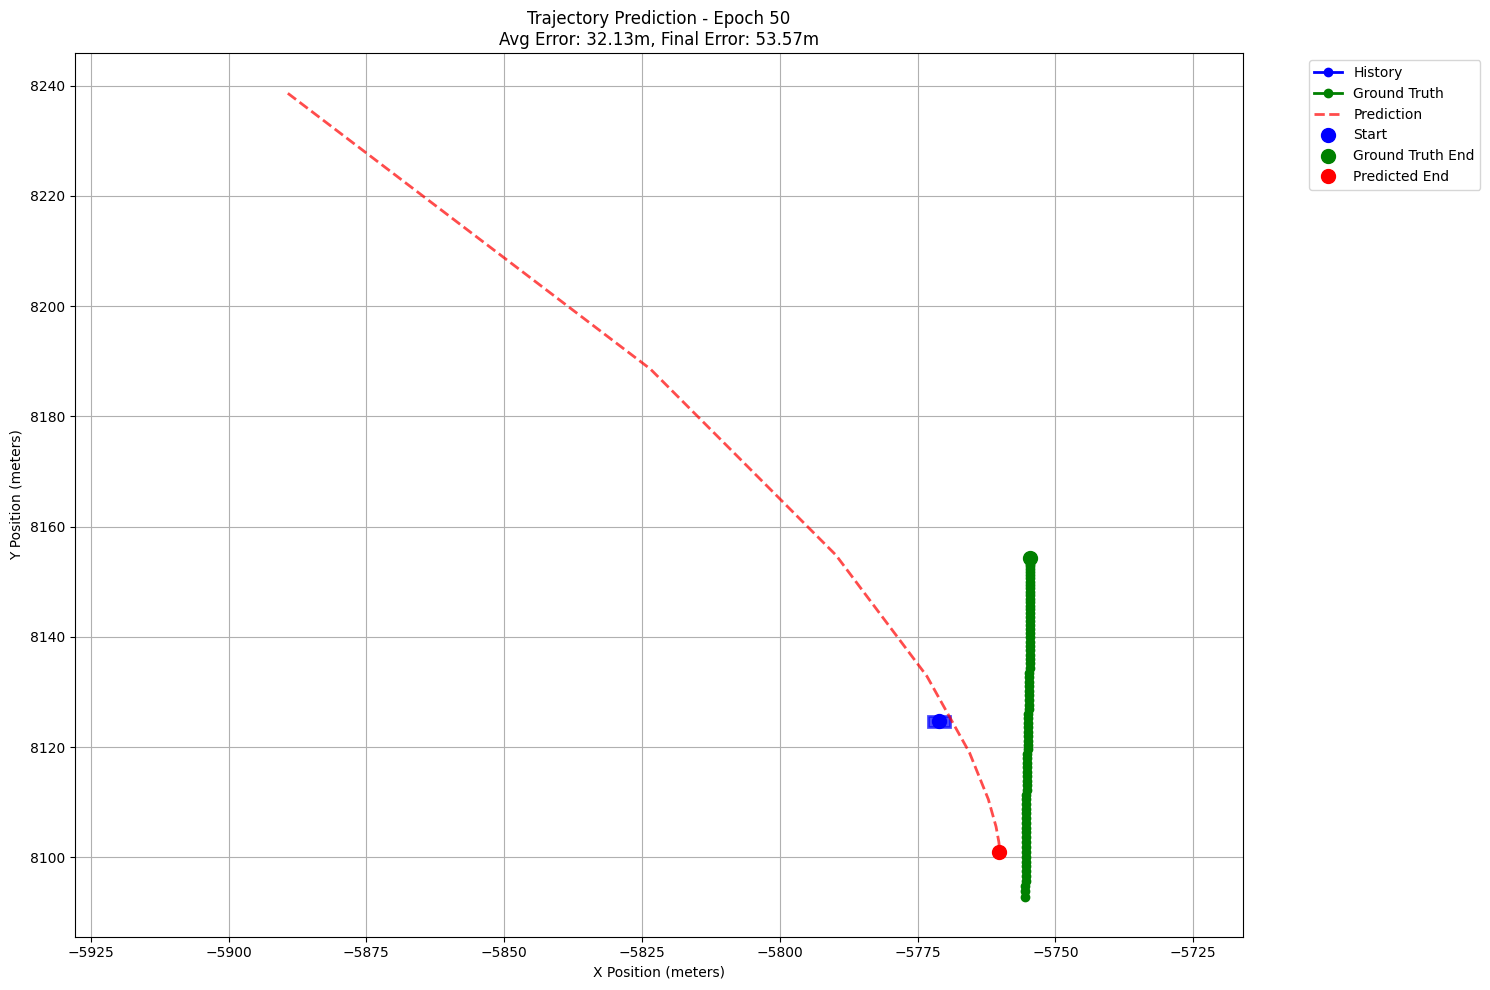


Epoch 100/200
epoch loss: 0.00021997024305164814
Average loss: 0.000220

Prediction Statistics:
Average prediction error: 27.48 meters
Final position error: 36.26 meters
Trajectory length - History: 11 steps, Future: 80 steps


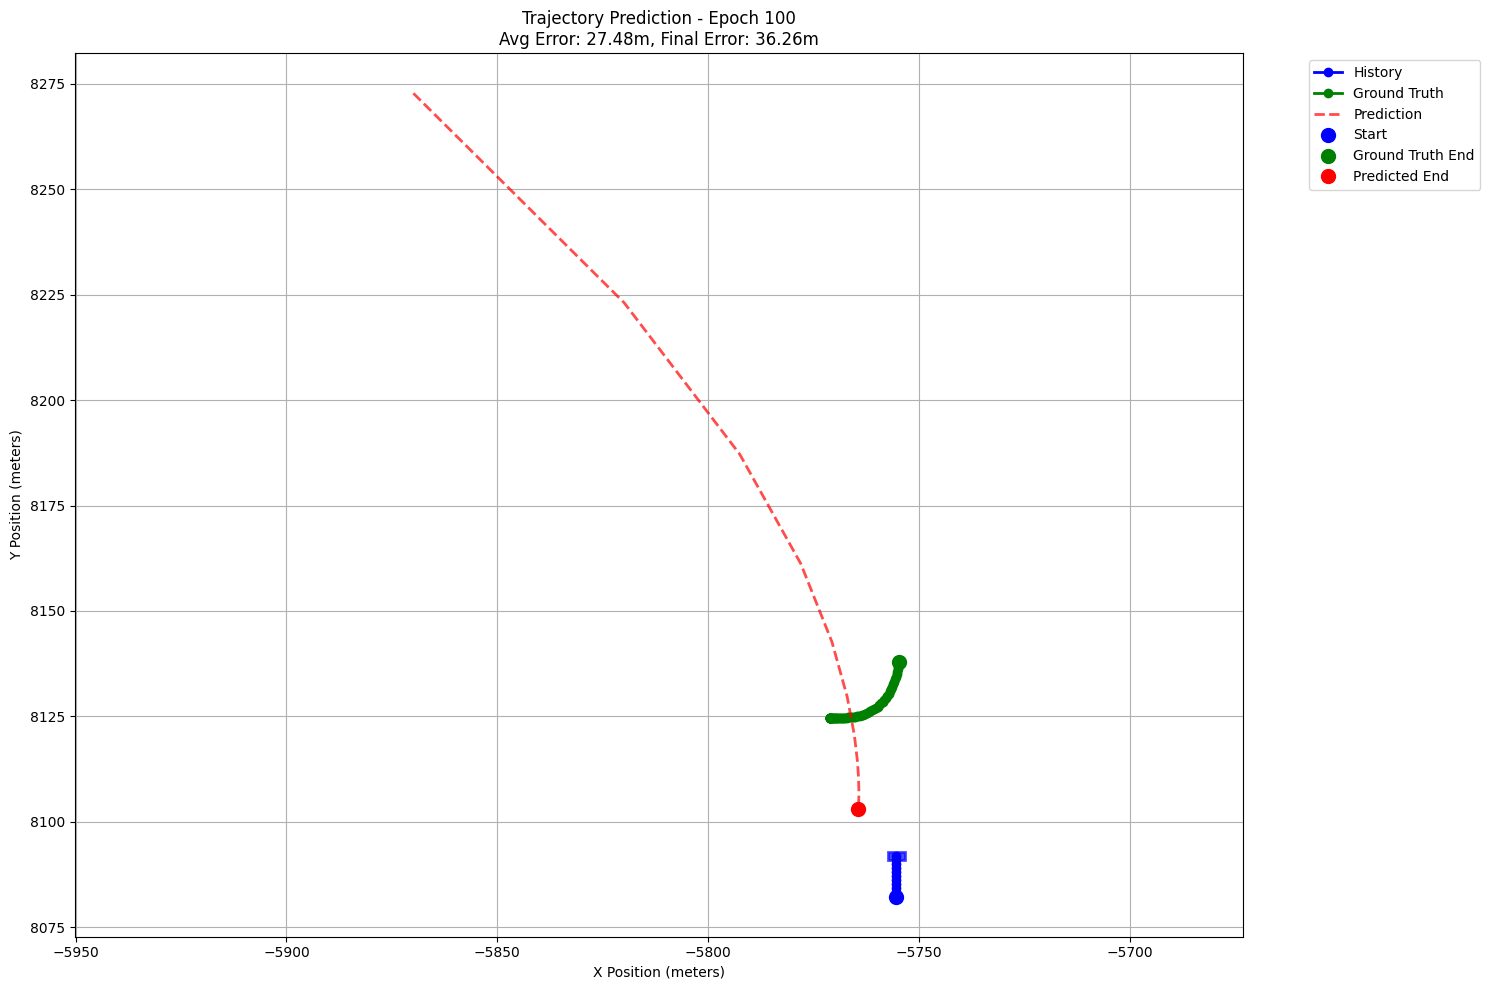


Epoch 150/200
epoch loss: 0.00021956907585263252
Average loss: 0.000220

Prediction Statistics:
Average prediction error: 34.68 meters
Final position error: 52.83 meters
Trajectory length - History: 11 steps, Future: 80 steps


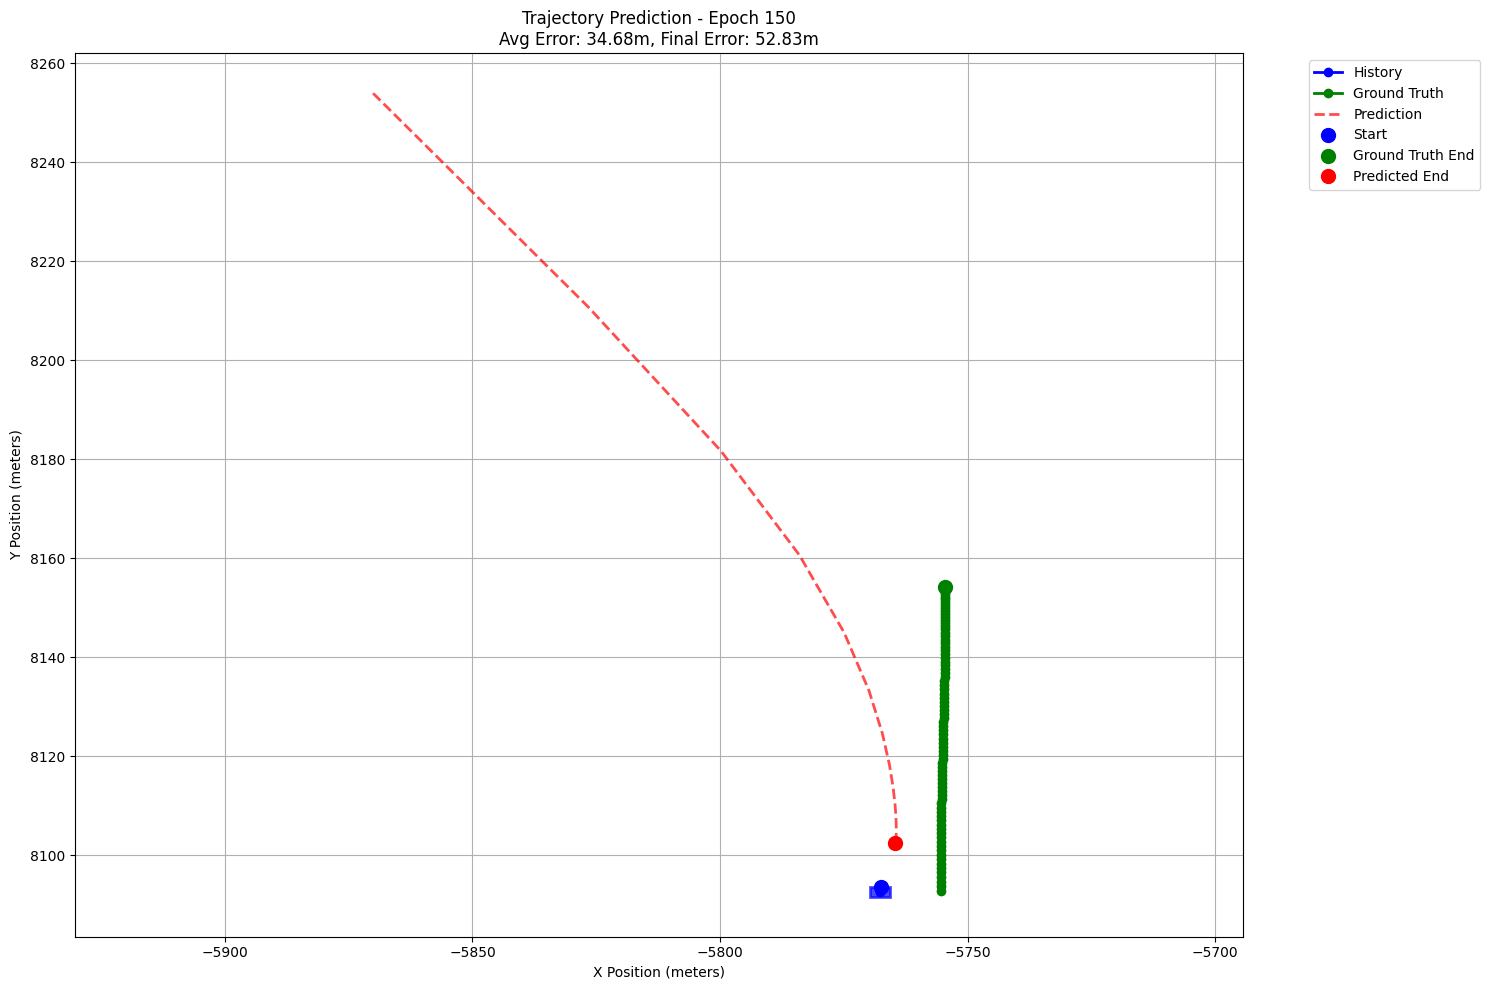


Epoch 200/200
epoch loss: 0.0001870831911219284
Average loss: 0.000187

Prediction Statistics:
Average prediction error: 398.04 meters
Final position error: 19.30 meters
Trajectory length - History: 11 steps, Future: 80 steps


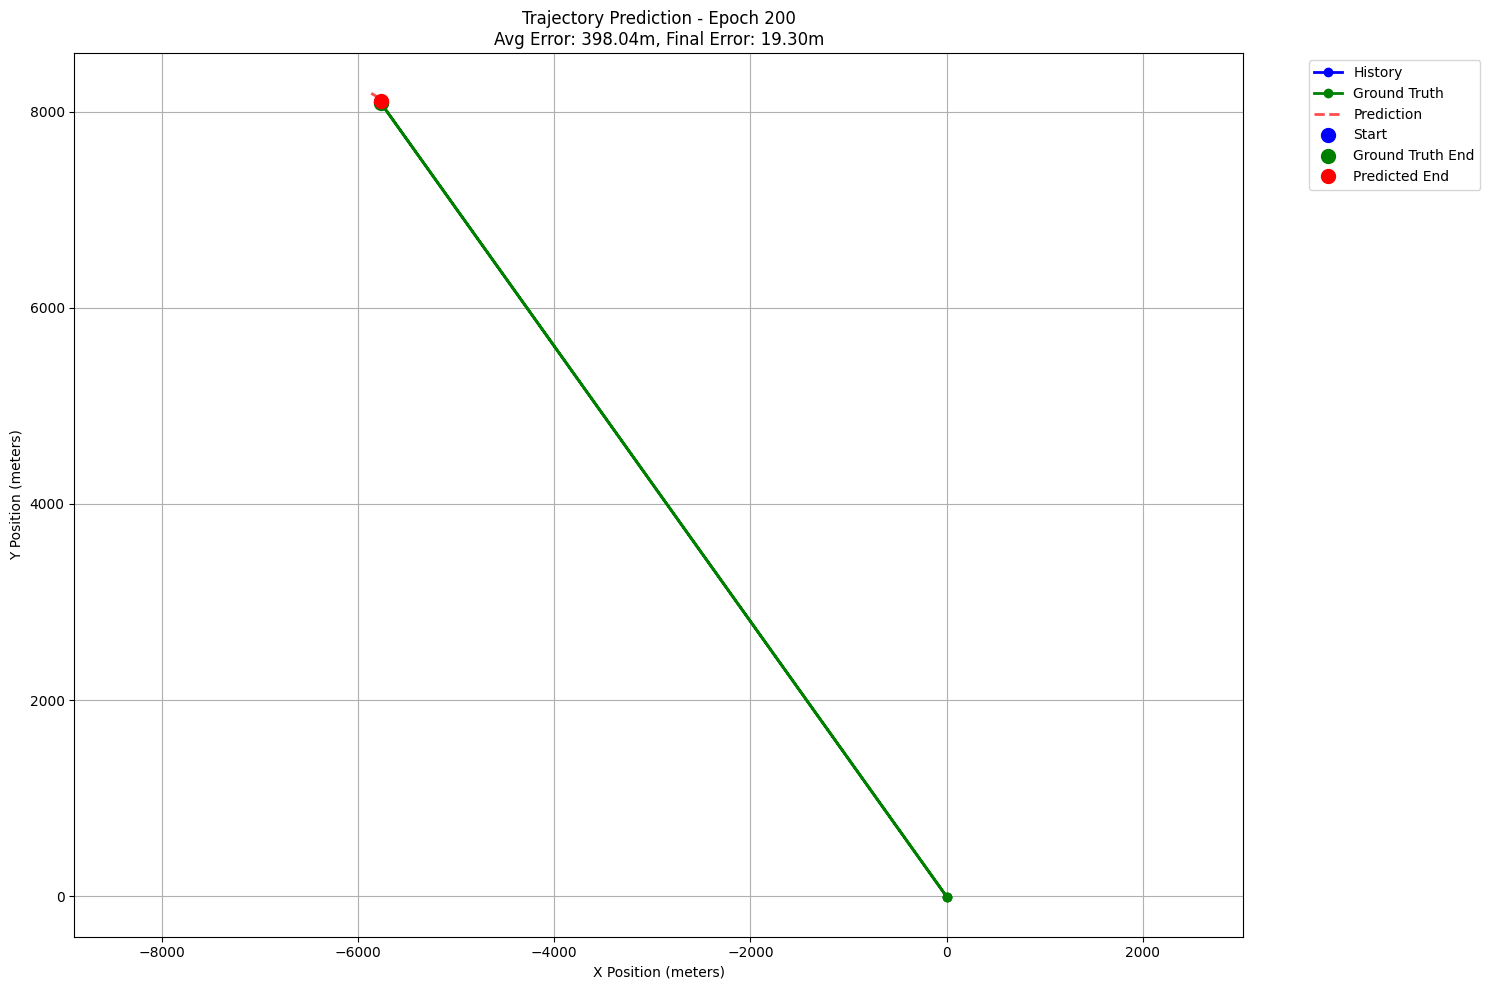


Training completed!
losses=[0.012103565968573093, 0.06846228986978531, 0.0026562665589153767, 0.003038260852918029, 0.008141383528709412, 0.008034399710595608, 0.004560668952763081, 0.0012403856962919235, 0.0004952969611622393, 0.0023761179763823748, 0.003374116960912943, 0.001872624852694571, 0.0006340669351629913, 0.00028378647402860224, 0.0006320640095509589, 0.00123629963491112, 0.0014708137605339289, 0.0013250025222077966, 0.0010972885647788644, 0.0006870912038721144, 0.00039624105556868017, 0.0002590474032331258, 0.000370398280210793, 0.0005180399748496711, 0.0006406402098946273, 0.0006550773396156728, 0.0005635229754261672, 0.0004263905284460634, 0.0003052162937819958, 0.00025412029935978353, 0.0002742745855357498, 0.00033271731808781624, 0.00040019943844527006, 0.0004299778083804995, 0.000439905357779935, 0.0003807774337474257, 0.00031495699658989906, 0.0002689870016183704, 0.0002326236863154918, 0.0002628373331390321, 0.0002769754210021347, 0.000281553395325318, 0.00032079761

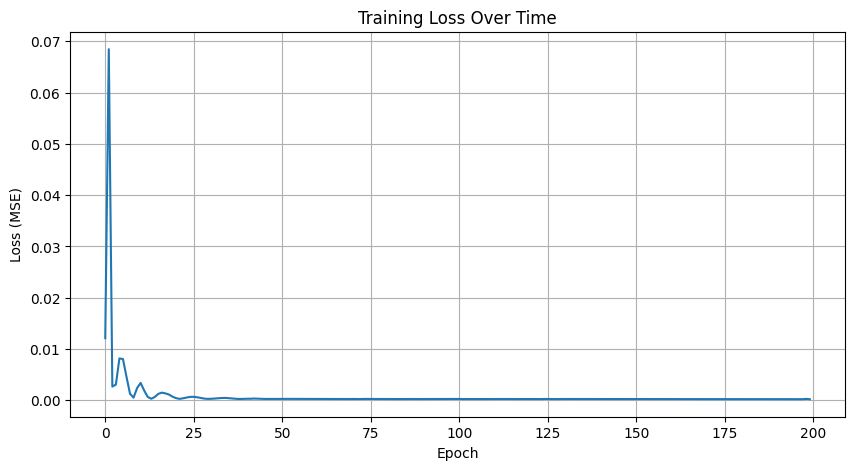

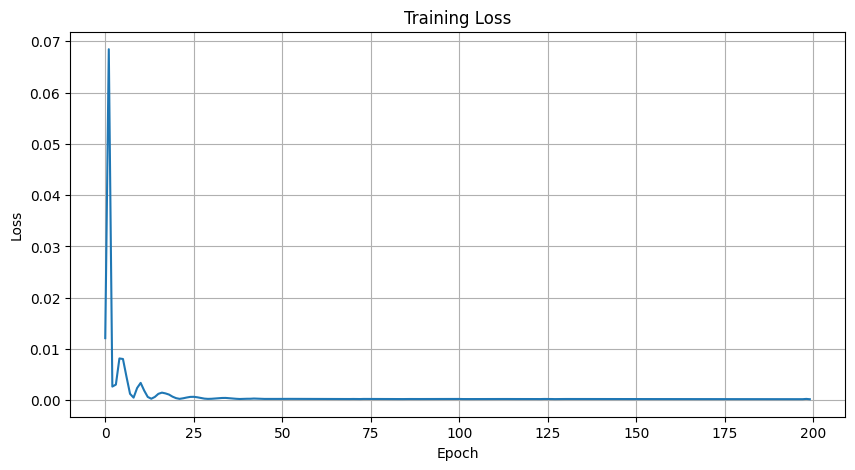

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from trajectory_dataset import TrajectoryDataset
from GRU_NN_model import TrajectoryPredictorGRU

class MainVehiclePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TrajectoryPredictorGRU()
    
    def forward(self, x):
        return self.base_model(x)
lr=0
epochs=0
def train_model(model, train_loader, epochs=epochs, lr=lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            hist = hist[:, 0:1].to(device)  # Take first vehicle
            fut = fut[:, 0:1].to(device)
            hist_valid = hist_valid[:, 0:1].to(device)
            fut_valid = fut_valid[:, 0:1].to(device)
            
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Visualize every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"epoch loss: {epoch_loss}")
            print(f"Average loss: {avg_loss:.6f}")

            
            model.eval()
            with torch.no_grad():
                # Get a sample trajectory
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Visualize the prediction
                visualize_prediction(hist, fut, pred, epoch, train_loader.dataset)
    
    print("\nTraining completed!")
    print(f'losses={losses}')
    torch.save(model.state_dict(), 'trajectory_model.pth')
    
    # Plot final training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()
    
    return model, losses

def visualize_prediction(history, future, prediction, epoch, dataset):
    """
    Visualize the model's prediction with enhanced styling.
    
    Args:
        history: tensor of shape [1, 11, 2] - normalized historical trajectory
        future: tensor of shape [1, 80, 2] - normalized ground truth future trajectory
        prediction: tensor of shape [1, 80, 2] - normalized predicted future trajectory
        epoch: current training epoch
        dataset: dataset object for denormalization
    """
    # Denormalize all trajectories
    hist_denorm = dataset.denormalize(history.cpu())
    fut_denorm = dataset.denormalize(future.cpu())
    pred_denorm = dataset.denormalize(prediction.cpu())

    # Convert to numpy for plotting
    hist_denorm = hist_denorm.numpy()[0]  # [11, 2]
    fut_denorm = fut_denorm.numpy()[0]    # [80, 2]
    pred_denorm = pred_denorm.numpy()[0]   # [80, 2]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot history trajectory
    plt.plot(hist_denorm[:, 0], hist_denorm[:, 1], 
            'o-', color='blue', alpha=1.0, linewidth=2,
            label='History')
    
    # Plot ground truth future trajectory
    plt.plot(fut_denorm[:, 0], fut_denorm[:, 1], 
            'o-', color='green', alpha=1.0, linewidth=2,
            label='Ground Truth')
    
    # Plot predicted future trajectory
    plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 
            '--', color='red', alpha=0.7, linewidth=2,
            label='Prediction')
    
    # Add vehicle rectangles at current position (last historical point)
    current_pos = hist_denorm[-1]
    # Assuming a standard vehicle size (you can adjust these)
    width, length = 2.0, 4.0
    
    # Vehicle rectangle at current position
    rect = Rectangle(
        (current_pos[0] - length/2, current_pos[1] - width/2),
        length, width,
        angle=0,  # We don't have yaw information here
        color='blue',
        alpha=0.7,
        linewidth=2
    )
    plt.gca().add_patch(rect)
    
    # Add markers for start and end points
    plt.plot(hist_denorm[0, 0], hist_denorm[0, 1], 'bo', markersize=10, label='Start')
    plt.plot(fut_denorm[-1, 0], fut_denorm[-1, 1], 'go', markersize=10, label='Ground Truth End')
    plt.plot(pred_denorm[-1, 0], pred_denorm[-1, 1], 'ro', markersize=10, label='Predicted End')
    
    # Calculate and display errors
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    plt.title(f'Trajectory Prediction - Epoch {epoch + 1}\n'
             f'Avg Error: {error:.2f}m, Final Error: {final_error:.2f}m')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print prediction statistics
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    print(f"\nPrediction Statistics:")
    print(f"Average prediction error: {error:.2f} meters")
    print(f"Final position error: {final_error:.2f} meters")
    print(f"Trajectory length - History: {len(hist_denorm)} steps, Future: {len(fut_denorm)} steps")
    
    plt.tight_layout()
    plt.show()

# The training function 

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    

    # Create and train model GRU
    model = TrajectoryPredictorGRU()  # This is the more sophisticated version
    model, losses = train_model(model, train_loader, epochs=200, lr=0.009)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()